# Prerequistite Packages

In [1]:
# Just comment and uncomment as necessary
# The output is kinda annoying and crowded

# Install packages
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install tensorflow


# Imports

In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


# Magic Constants

In [3]:
# Filename settings
FILE_PREFIX = "./data/"
train_filename = FILE_PREFIX + "train.csv"
test_filename = FILE_PREFIX + "test.csv"

# Scrap me: test.csv doesn't include the transported column! Should always be false
# Set to False if we want to only train and test on the train csv
loadSeparateTestCsv = False

# Set to true when we want to generate a submission for kaggle
testSubmission = False

# Common utility functions


def checkNotSubmitting():
    assert not testSubmission, "Don't run this cell if creating a submission"


# Load and Split the File

In [4]:
# We might want to mount a shared google drive so we don't have to reupload
# everytime the session expires
trainData = pd.read_csv(train_filename)
data = None
testData = None
if loadSeparateTestCsv:
    testData = pd.read_csv(test_filename)
    data = pd.concat([trainData, testData])
else:
    data = trainData

if testSubmission:
    data = pd.read_csv(test_filename)

# FEATURE MODIFICATION SETTINGS
dropCols = ["PassengerId", "Name"]  # Columns to drop entirely
# Binary columns to replace with 1's and 0's
binaryCols = ["CryoSleep", "VIP", "Transported"]
# Category columns that are commonly shared, dummies are built from these
categoricalCols = []
# Ok my idea for this is that for the fairly unique columns we should generate a numerical
# id for each unique entry, then replace the column with the id. Generating dummies with these
# just leads to a feature explosion.
uniqueGeneratorCols = ["Cabin", "HomePlanet", "Destination"]
###############################

# Not sure why these features have NaN's, but we can (safely?) replace them with 0's.
data["CryoSleep"] = data["CryoSleep"].fillna(value=False)
data["VIP"] = data["VIP"].fillna(value=False)
data["VRDeck"] = data["VRDeck"].fillna(value=0)
data["ShoppingMall"] = data["ShoppingMall"].fillna(value=0)
data["RoomService"] = data["RoomService"].fillna(value=0)
data["FoodCourt"] = data["FoodCourt"].fillna(value=0)
data["Spa"] = data["Spa"].fillna(value=0)
# weird ones
data["Cabin"] = data["Cabin"].fillna(value="UNKNOWN")
data["HomePlanet"] = data["HomePlanet"].fillna(value="UNKNOWN")
data["Destination"] = data["Destination"].fillna(value="UNKNOWN")
data["Age"] = data["Age"].fillna(value=-1)

# test.csv doesn't have the transported column
if testSubmission and "Transported" in binaryCols:
    binaryCols.remove("Transported")
# We want to keep the passengerIds for submission
if testSubmission and "PassengerId" in dropCols:
    dropCols.remove("PassengerId")

data = data.drop(columns=dropCols)
for c in binaryCols:
    data[c] = data[c].astype(int)
data = pd.get_dummies(data, columns=categoricalCols)
# Generate unique ids per column
for c in uniqueGeneratorCols:
    data[c] = data[c].astype("category").cat.rename_categories(
        range(data[c].nunique()))

# We don't want any nan data
assert (not data.isnull().values.any())

yCol = "Transported"
X, y = None, None
if not testSubmission:
    X = data.drop(columns=yCol)
    y = data[yCol]
else:
    X = data

X_train, X_test, y_train, y_test = None, None, None, None
if not testSubmission:
    if testData is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train = X[: trainData.shape[0]]
        X_test = X[trainData.shape[0]:]
        y_train = y[: trainData.shape[0]]
        y_test = y[trainData.shape[0]:]
else:
    X_test = X

# print(data.head())
# print(data.describe())


# Data Visualization

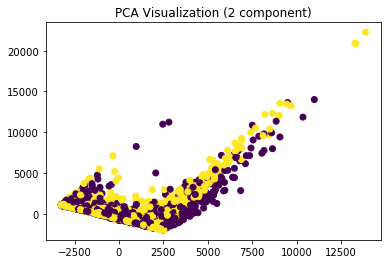

In [5]:
# tSNE or PCA here

checkNotSubmitting()

pcaComps = 2
pca = PCA(n_components=pcaComps)
pca_train = pca.fit_transform(X_train, y_train)
pca_test = pca.transform(X_test)

if pcaComps == 2:
    plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train)
plt.title(f"PCA Visualization ({pcaComps} component)")
plt.show()

# Feature importance graphing
# todo
estimators = 100  # todo: grid search me!
#gbc = GradientBoostingClassifier(n_estimators=100)
#gbc.fit(X_train, y_train)
# todo: render the important features
# look at my roommates code here: https://github.com/justincdavis/BowlGamesNN/blob/main/CFBowlGamesNN.ipynb


# Find Models

As we are predicting which passengers have been sent to the anomaly, this is naturally a classification problem.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

Here, we'll explore supervised, classification models. Some are better than others.

In [6]:
# Models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error


## SVCs

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
kernels = {"poly", "rbf", "sigmoid"}

for kernel in kernels:
    clf = SVC(kernel=kernel, gamma="scale").fit(X=X_train, y=y_train)
    predictions = clf.predict(X=X_test)

    print(f"Model: {clf}")
    print(f"Kernel: {kernel}")
    print(f"The F1 score is {f1_score(y_true=y_test, y_pred=predictions)}")
    print(
        f"The MSE is {mean_squared_error(y_true=y_test, y_pred=predictions)}\n")


Model: SVC(kernel='poly')
Kernel: poly
The F1 score is 0.781391830559758
The MSE is 0.265869365225391

Model: SVC(kernel='sigmoid')
Kernel: sigmoid
The F1 score is 0.495246717971933
The MSE is 0.5128794848206072

Model: SVC()
Kernel: rbf
The F1 score is 0.8069048574869531
The MSE is 0.22125114995400183



In [8]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

clf = LinearSVC(penalty="l1", loss="squared_hinge",
                dual=False).fit(X=X_train, y=y_train)
predictions = clf.predict(X=X_test)

print(f"Model: {clf}")
print(f"The f1 score is {f1_score(y_true=y_test, y_pred=predictions)}")
print(
    f"The MSE is {mean_squared_error(y_true=y_test, y_pred=predictions)}\n")

clf = LinearSVC(penalty="l2", dual=False).fit(X=X_train, y=y_train)
predictions = clf.predict(X=X_test)

print(f"Model: {clf}")
print(f"The f1 score is {f1_score(y_true=y_test, y_pred=predictions)}")
print(
    f"The MSE is {mean_squared_error(y_true=y_test, y_pred=predictions)}\n")


Model: LinearSVC(dual=False, penalty='l1')
The f1 score is 0.7883340698188245
The MSE is 0.2203311867525299

Model: LinearSVC(dual=False)
The f1 score is 0.7884955752212389
The MSE is 0.21987120515179392



## Naive Bayes

In [9]:
naive_bayes_models = (GaussianNB(), BernoulliNB())
for model in naive_bayes_models:
    clf = model.fit(X=X_train, y=y_train)
    predictions = clf.predict(X=X_test)

    print(f"Model: {clf}")
    print(f"The f1 score is {f1_score(y_true=y_test, y_pred=predictions)}")
    print(
        f"The MSE is {mean_squared_error(y_true=y_test, y_pred=predictions)}\n")


Model: GaussianNB()
The f1 score is 0.7635968092820884
The MSE is 0.2999080036798528

Model: BernoulliNB()
The f1 score is 0.7181688125894136
The MSE is 0.2718491260349586



## Stochastic Gradient Descent

In [10]:
losses = {'hinge', 'log_loss', 'modified_huber', 'squared_hinge', 'perceptron',
          'squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'}
penalties = {'l2', 'l1', 'elasticnet'}


best_f1 = 0
lowest_mse = 1
best_model_f1 = SGDClassifier()
best_model_mse = SGDClassifier()

for loss in losses:
    for penalty in penalties:
        clf = SGDClassifier(loss=loss, penalty=penalty,
                            max_iter=5000, n_jobs=-1).fit(X=X_train, y=y_train)
        predictions = clf.predict(X=X_test)

        f1 = f1_score(y_true=y_test, y_pred=predictions)
        mse = mean_squared_error(y_true=y_test, y_pred=predictions)

        if (f1 > best_f1):
            best_f1 = f1
            best_model_f1 = clf
        if (mse < lowest_mse):
            lowest_mse = mse
            best_model_mse = clf

print(f"Best model: {best_model_f1}")
print(f"The best f1 score is {best_f1}")
print(f"Best model: {best_model_mse}")
print(f"The best MSE is {lowest_mse}\n")


Best model: SGDClassifier(loss='perceptron', max_iter=5000, n_jobs=-1, penalty='l1')
The best f1 score is 0.8031936127744511
Best model: SGDClassifier(loss='perceptron', max_iter=5000, n_jobs=-1, penalty='l1')
The best MSE is 0.22677092916283348



## SVMs

In [11]:
# 2c_SL_SVM_Kernel.ipynb
# TODO SVM takes A REALLY LONG TIME (30+ and it didn't finish), even with reduced parameters
#      It was slow even on MIO, so not sure what to do there

# params = {
#     "kernel": ["linear", "poly"],
#     "degree": [1, 2, 3],
#     "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
#     "random_state": [0],
#     "gamma": ["auto"]
# }
# clf = GridSearchCV(estimator=SVC(), param_grid=params,
#                    scoring="f1_weighted", cv=10, n_jobs=-1)

# clf.fit(X=X_train, y=y_train)
# print(f"The best estimator is {clf.best_estimator_}")
# print(f"Best score on training data: {clf.best_score_}")

# testScore = clf.score(X=X_test, y=y_test)
# print(f"Best score on testing data: {testScore}")


# Feature selection

Feature selection is a feature learning approach to **select a subset of the features** from our data to use for a particular task.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression

checkNotSubmitting()

# References homework 4a_FL_Feature_Selection.ipynb
# Create a StandardScalar to standardize the passenger features
scalar = sk.preprocessing.StandardScaler().fit(X=X_train)
# Don't want to change the original values
XT_train = scalar.transform(X=X_train)
XT_test = scalar.transform(X=X_test)


## Filter Methods (Mutual Information)

Filter methods directly **select a subset from the features** using a metric that they filter by.

An example filter method would be using the **mutual information score between features to determine the redundancy** in the data. 
With the goal of reducing dimensionality by minimizing redundancy we can then **remove features based on the highest amount of redundancy calculated by the mutual information.**

\+ Low computation cost

\+ Robust to overfitting. 

\+ Good value for computation time and effort 

\- Filter methods are also greedy which means that they may not get the best possible results.

In [13]:
print(f"---------------------------------Mutual Information-------------------------------------")

# Create set of models to estimate on
model_estimators = [KNeighborsClassifier, GaussianNB]

# Select the best features based on mutual information score from the training data,
#  then transform XT_train and XT_test into the new subset of selected features
for model in model_estimators:
    print(f"Model: {model}")
    # Set up tracker variables
    best_k_MI = 0
    best_k_test = 0
    best_predictions_MI = np.zeros(1)
    best_predictions_test = np.zeros(1)
    lowest_mse_MI = 1
    lowest_mse_test = 1

    max_k = 11
    for k in range(1, max_k):
        mutual_information_transformer = sk.feature_selection.SelectKBest(
            score_func=sk.feature_selection.mutual_info_regression,
            k=k
        ).fit(X=XT_train, y=y_train)
        MI_X_train = mutual_information_transformer.transform(X=XT_train)
        MI_X_test = mutual_information_transformer.transform(X=XT_test)

        # Create model and estimate
        miEst = model().fit(X=MI_X_train, y=y_train)
        train_predictions = miEst.predict(X=MI_X_train)
        test_predictions = miEst.predict(X=MI_X_test)

        mse_MI = mean_squared_error(y_true=y_train, y_pred=train_predictions)
        mse_test = mean_squared_error(y_true=y_test, y_pred=test_predictions)
        if (mse_MI < lowest_mse_MI):
            best_k_MI = k
            lowest_mse_MI = mse_MI
            best_predictions_MI = train_predictions
        if (mse_test < lowest_mse_test):
            best_k_test = k
            lowest_mse_test = mse_test
            best_predictions_test = test_predictions

    print(
        f"The lowest MSE for the MI selected features is {lowest_mse_MI} with k = {best_k_MI}")
    print(
        f"The f1 score is {f1_score(y_train, best_predictions_MI, average='weighted')}\n")
    print(
        f"The lowest MSE for on the test data is {lowest_mse_test} with k = {best_k_test}")
    print(
        f"The f1 score is {f1_score(y_test, best_predictions_test, average='weighted')}\n")


---------------------------------Mutual Information-------------------------------------
Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
The lowest MSE for the MI selected features is 0.1579996932044792 with k = 8
The f1 score is 0.8419996003996727

The lowest MSE for on the test data is 0.22309107635694572 with k = 6
The f1 score is 0.7756570603616969

Model: <class 'sklearn.naive_bayes.GaussianNB'>
The lowest MSE for the MI selected features is 0.2774965485503912 with k = 1
The f1 score is 0.715874374412175

The lowest MSE for on the test data is 0.29254829806807725 with k = 10
The f1 score is 0.6897882631377391



## Wrapper Methods (Recursive Feature Elimination)

Wrapper methods will **loop through the subset selection and model training stages.**

An example wrapper method is recursive feature elimination (RFE). RFE utilizes models that provide a coefficient for each feature that represents its applicability or use in determining the target of the model.

\+ Usually perform better than filter methods. 

\- They are also usually greedy methods, will 

\- Require more computation time than filter methods 

\- Prone to overfitting.

In [14]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet


In [15]:
print(f"---------------------------------Recursive Elimination----------------------------------")

# RFE only works with LinearRegression-like models for some reason
model_estimators = [LinearRegression(
    n_jobs=-1), Ridge(), Lasso(), ElasticNet()]

for model in model_estimators:
    lowest_mse_rfe = 1
    lowest_mse_test = 1
    best_step_rfe = 0
    best_step_test = 0
    most_important_rfe = list()
    most_important_test = list()

    # Use recursive feature elimination (RFE) object to determine the k features to select
    # from X_train using a variable step size
    max_steps = 11
    for step in range(1, 11):
        rfe_transformer = sk.feature_selection.RFE(
            estimator=model, step=step).fit(X=XT_train, y=y_train)
        rfe_X_train = rfe_transformer.transform(X=XT_train)
        rfe_X_test = rfe_transformer.transform(X=XT_test)

        rfeEst = model.fit(rfe_X_train, y_train)
        train_predictions = rfeEst.predict(X=rfe_X_train)
        test_predictions = rfeEst.predict(X=rfe_X_test)

        mse_rfe = mean_squared_error(y_true=y_train, y_pred=train_predictions)
        mse_test = mean_squared_error(y_true=y_test, y_pred=test_predictions)

        if (mse_rfe < lowest_mse_rfe):
            best_step_rfe = step
            lowest_mse_rfe = mse_rfe
            most_important_rfe = list(
                data.columns[:11][rfe_transformer.support_])
        if (mse_test < lowest_mse_test):
            best_k_test = k
            lowest_mse_test = mse_test
            most_important_test = list(
                data.columns[:11][rfe_transformer.support_])

    print(f"Model: {model}")
    print(
        f"The lowest MSE for the RFE selected features is {lowest_mse_rfe} with step = {best_step_rfe}")
    print(
        f"The most important features as determined by RFE were {list(data.columns[:11][rfe_transformer.support_])}")
    print(
        f"The lowest MSE for on the test data is {lowest_mse_test} with step = {best_step_test}\n")


---------------------------------Recursive Elimination----------------------------------
Model: LinearRegression(n_jobs=-1)
The lowest MSE for the RFE selected features is 0.1752113582199001 with step = 1
The most important features as determined by RFE were ['CryoSleep', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck']
The lowest MSE for on the test data is 0.17973957017987158 with step = 0

Model: Ridge()
The lowest MSE for the RFE selected features is 0.1752113599382254 with step = 1
The most important features as determined by RFE were ['CryoSleep', 'RoomService', 'FoodCourt', 'Spa', 'VRDeck']
The lowest MSE for on the test data is 0.1797385807671686 with step = 0

Model: Lasso()
The lowest MSE for the RFE selected features is 0.24999359371985475 with step = 1
The most important features as determined by RFE were ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
The lowest MSE for on the test data is 0.2501181735535869 with step = 0

Model: ElasticNet()
The lowest MSE for t

## Embedded Methods

Embedded methods will loop through the subset selection, model training and evaluation stages.

Based on the trained model parameters and performance, the embedded method will select a new subset. Examples of embedded feature selection methods are any of the regularization based regression methods we discussed previously.

\+ Has benefits of filter and wrapper methods 

\+ Higher performance

\+ Usually results in much better results

\- More computation time

In [16]:
from sklearn.linear_model import RidgeCV, LassoCV


In [17]:
print(f"---------------------------------Lasso Embedded Method----------------------------------")

model_estimators = [RidgeCV, LassoCV]
alphas = np.linspace(1, 100, 1000)

for model in model_estimators:

    max_alphas = 1001
    modelEst = model(alphas=alphas).fit(X=XT_train, y=y_train)

    train_predictions = modelEst.predict(XT_train)
    test_predictions = modelEst.predict(XT_test)

    mse_model = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)

    print(modelEst)
    print(f"The best mean squared error when training is {mse_model}")
    print(f"The best mean squared error on the test data is {mse_test}\n")


---------------------------------Lasso Embedded Method----------------------------------
RidgeCV(alphas=array([  1.        ,   1.0990991 ,   1.1981982 ,   1.2972973 ,
         1.3963964 ,   1.4954955 ,   1.59459459,   1.69369369,
         1.79279279,   1.89189189,   1.99099099,   2.09009009,
         2.18918919,   2.28828829,   2.38738739,   2.48648649,
         2.58558559,   2.68468468,   2.78378378,   2.88288288,
         2.98198198,   3.08108108,   3.18018018,   3.27927928,
         3.37837838,   3.47747748,   3.57657658,   3.67567568,
         3.77477477,   3.87387387,   3.97297297,...
        96.92792793,  97.02702703,  97.12612613,  97.22522523,
        97.32432432,  97.42342342,  97.52252252,  97.62162162,
        97.72072072,  97.81981982,  97.91891892,  98.01801802,
        98.11711712,  98.21621622,  98.31531532,  98.41441441,
        98.51351351,  98.61261261,  98.71171171,  98.81081081,
        98.90990991,  99.00900901,  99.10810811,  99.20720721,
        99.30630631,  99.

# Feature extraction

In [18]:

from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.manifold import SpectralEmbedding

checkNotSubmitting()


## Spectral Embedding + SVC

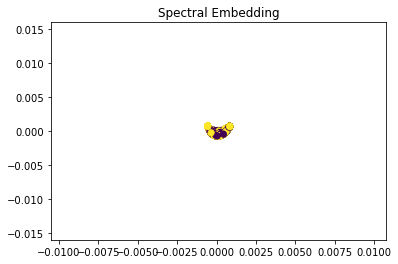

The Spectral Embedding + Linear SVM scores an F-1 = 0.000.


In [19]:
# Justin: This is copied from 4b_FL_Feature_Extraction.ipynb
#         We can toy around to make it better, but this is a start

spectral_transformer = SpectralEmbedding().fit(X=X_train, y=y_train)
spectral_embedding = spectral_transformer.embedding_
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=y_train)
plt.title("Spectral Embedding")
plt.show()

X_complete = pd.concat([X_train, X_test])
size_Xtrain = len(X_train)

spectral_model = SpectralEmbedding()
spectral_train = spectral_model.fit_transform(
    X=X_complete[:size_Xtrain], y=y_train
)
spectral_test = spectral_model.fit_transform(
    X=X_complete[size_Xtrain:], y=y_test
)

spectral_svc = LinearSVC().fit(X=spectral_train, y=y_train)
print(
    f"The Spectral Embedding + Linear SVM scores an F-1 = {f1_score(y_test, spectral_svc.predict(spectral_test)):.3f}.")


# Model Testing

Now we have the reduced dataset with high mutual information between each feature, time to run some models


In [20]:
# knn or svm?
# Justin: I think that KNN performed fairly well in the Filter + Mutual 
#         Information testing
#         For the SVMs, they performed relatively well, but the f1 scores weren't
#         nearly as close to the KNN
#         One thing to note is that I ran the models on the original dataset and some
#         on the transformed/normalized dataset
#         Does it matter? Maybe.
#
# TODO    Test it out alone or in combination with other methods.
# TODO    Run the same models on the reduced or extracted datasets

checkNotSubmitting()


# Neural network

We can never go wrong with a neural network.

So far, this is the highest scoring model. However, we can probably get better
scores by tweaking the number of nodes in each layer, number of dropout layers,
etc.

## Model Parameters

In [21]:
##################
activation = "sigmoid"
outputActivation = "sigmoid"  # This should not change
hiddenExpansionSize = 50
denseHiddenLayers = 3
autoencoderCompressionSize = 6
##################

# Andrew's model arch notes:
# - do we progressively collapse when autoencoding or dense map straight to it?
# - mess around with dropout layers to reduce overfitting

checkNotSubmitting()

layers = []
layers.append(tf.keras.layers.Dense(hiddenExpansionSize, input_shape=(
    X.shape[1],), activation=activation, name=f"input_{X.shape[1]}x1"))
for i in range(denseHiddenLayers):
    layers.append(tf.keras.layers.Dense(hiddenExpansionSize,
                  activation=activation, name=f"dense_{i}"))
layers.append(tf.keras.layers.Dense(autoencoderCompressionSize,
              activation=activation, name="autoenc"))
layers.append(tf.keras.layers.Dense(
    2, activation=outputActivation, name="output"))

dnn = tf.keras.Sequential(layers)
dnn.build()
dnn.summary()

nnDefaultWeights = dnn.get_weights()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11x1 (Dense)          (None, 50)                600       
                                                                 
 dense_0 (Dense)             (None, 50)                2550      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 autoenc (Dense)             (None, 6)                 306       
                                                                 
 output (Dense)              (None, 2)                 14        
                                                                 
Total params: 8,570
Trainable params: 8,570
Non-trainabl

## Neural network compilation and training

In [22]:
#####################
# TRAINING PARAMETERS
learningRate = 0.001
#lossFunc = "binary_crossentropy"
lossFunc = "mae"
epochs = 30
batchSize = 1000
#####################

if not testSubmission:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
    #optimizer = tf.keras.optimizers.SGD()

    dnn.compile(optimizer, loss=lossFunc, metrics=["accuracy"])

    dnn.set_weights(nnDefaultWeights)  # Reset if we already fit
    dnn.fit(X_train, y_train, batch_size=batchSize, epochs=epochs)

    nnMetrics = dnn.evaluate(X_test, y_test)
    print(f"NN evaluated accuracy: {nnMetrics}")
else:
    predictions = dnn.predict(X_test.drop(
        columns=["PassengerId"]), batch_size=batchSize)
    # We have 2 output nodes, we want to take the index of the node with greater activation
    predictionsBinary = np.argmax(predictions, axis=1)
    predictionsBinary = 1 - predictionsBinary  # Invert the result
    outData = pd.DataFrame()
    outData["PassengerId"] = X_test["PassengerId"]
    outData["Transported"] = predictionsBinary.astype(bool)
    outData.to_csv("results.csv", index=False)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).